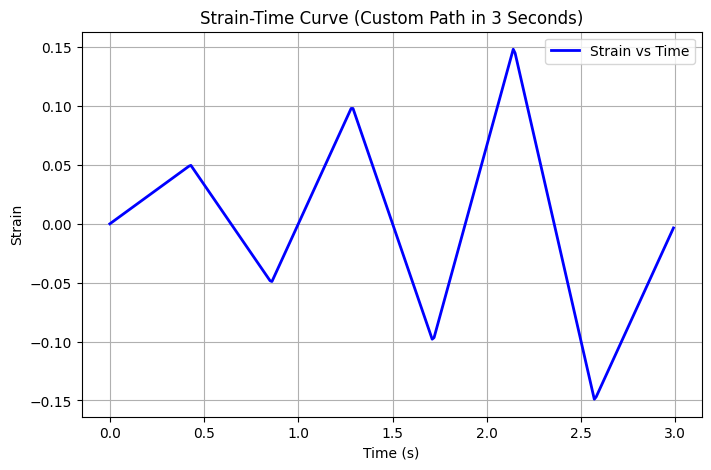

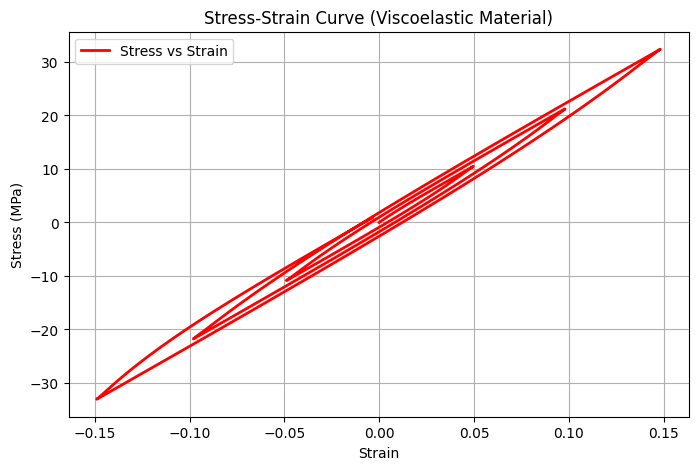

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad

# Parameters for the viscoelastic model
A = 200  # Elastic stiffness matrix in MPa
Q = 10   # Kernel decay rate
D = 50   # Damping coefficient in MPa·s
dt = 0.01  # Time step

# Time array
total_time = 3  # Total time for custom strain path (3 seconds)
time = np.arange(0, total_time, dt)  # Time array

# Define custom strain points and corresponding time points
custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]
custom_time_points = np.linspace(0, total_time, len(custom_strain_points))

# Interpolate to create the strain path
strain = np.interp(time, custom_time_points, custom_strain_points)

# Strain rate (dE/dt) using numerical differentiation
strain_rate = np.gradient(strain, dt)

# Initialize stress array for storing computed stress values
stress = np.zeros_like(time)

# Compute stress using the convolution integral
for i in range(1, len(time)):
    # Elastic stress component
    elastic_stress = A * strain[i]
    
    # Viscoelastic stress component
    viscoelastic_stress = 0
    for j in range(i):
        kernel = np.exp(-Q * (time[i] - time[j]))  # Decaying kernel
        viscoelastic_stress += kernel * D * strain_rate[j] * dt  # Convolution for viscoelastic contribution
    
    # Total stress is the sum of elastic and viscoelastic components
    stress[i] = elastic_stress + viscoelastic_stress
# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time", color='b', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Custom Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color='r', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Viscoelastic Material)")
plt.grid(True)
plt.legend()
plt.show()

# Convert to torch tensors for training
strain_tensor = torch.tensor(strain, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
stress_tensor = torch.tensor(stress, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

# Create dataset and dataloader
dataset = TensorDataset(strain_tensor, stress_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)



In [13]:
# Convexity Enforcement: Softplus Squared (Convex Activation Function)
class SoftplusSquared(nn.Module):
    def forward(self, x):
        return torch.log(1 + torch.exp(x)) ** 2

# Define the neural network for Potential W
class PotentialW(nn.Module):
    def __init__(self):
        super(PotentialW, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )

    def forward(self, strain):
        strain = strain.view(-1, 1)
        W = self.fc(strain)
        return W

# Define the neural network for Potential V
class PotentialV(nn.Module):
    def __init__(self):
        super(PotentialV, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )
        self.C1 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.C2 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)

    def forward(self, strain, alpha):
        delta = self.C1 * strain + self.C2 * alpha
        delta = delta.view(-1, 1)
        V = self.fc(delta)
        return V
    
    # Define the neural network for Potential G
class PotentialG(nn.Module):
    def __init__(self):
        super(PotentialG, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )

    def forward(self, beta, strain):
        beta = beta.view(-1, 1)
        G = self.fc(beta)
        return G

# Define functions to compute total stress and evolve internal variable alpha

# Compute total stress: dW/dE + dV/dE
def compute_total_stress(W_model, V_model, strain, alpha):
    # Forward pass through W_model and V_model
    W = W_model(strain)
    V = V_model(strain, alpha)

    # Sum the output to ensure it's scalar for grad
    W_sum = W.sum()
    V_sum = V.sum()

    # Compute the gradient dW/dE and dV/dE (we use sum to make output scalar)
    dW_dE = grad(W_sum, strain, create_graph=True)[0]
    dV_dE = grad(V_sum, strain, create_graph=True)[0]

    # Total stress is the sum of elastic and viscoelastic stress contributions
    total_stress = dW_dE + dV_dE
    return total_stress

# Evolve alpha using G model
def evolve_alpha(G_model, beta, strain):
    alpha_evolution = G_model(beta, strain)
    return alpha_evolution

# Compute internal stress beta from V model
def compute_internal_stress(V_model, strain, alpha):
    # Forward pass through the V model
    V = V_model(strain, alpha)

    # Sum the output to ensure it's scalar for grad
    V_sum = V.sum()

    # Compute the gradient dV/dalpha (internal stress)
    beta = -grad(V_sum, alpha, create_graph=True)[0]
    return beta


# Define the complete viscoelastic model
class ViscoelasticModel(nn.Module):
    def __init__(self, W_model, V_model, G_model):
        super(ViscoelasticModel, self).__init__()
        self.W_model = W_model
        self.V_model = V_model
        self.G_model = G_model

    def forward(self, strain, alpha):
        # Step 1: Compute internal stress beta using equation (28)
        beta = compute_internal_stress(self.V_model, strain, alpha)

        # Step 2: Evolve alpha using equation (27)
        alpha_evolution = evolve_alpha(self.G_model, beta, strain)

        # Step 3: Compute total stress using equation (26)
        total_stress = compute_total_stress(self.W_model, self.V_model, strain, alpha)

        return total_stress, alpha_evolution



In [14]:
# Instantiate the models
W_model = PotentialW()
V_model = PotentialV()
G_model = PotentialG()

# Instantiate the viscoelastic model
viscoelastic_model = ViscoelasticModel(W_model, V_model, G_model)

# Define loss function (Mean Squared Error) and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(viscoelastic_model.parameters(), lr=0.001)

# Training loop
epochs = 1000
delta_t = 0.01  # Time step size for forward Euler integration

for epoch in range(epochs):
    # Loop through the data loader batches
    for batch_idx, (strain_batch, true_stress_batch) in enumerate(data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Initialize alpha to zeros with the same shape as the batch size of strain_batch
        alpha = torch.zeros_like(strain_batch)  # Make sure alpha matches strain_batch size

        # Forward pass: compute predicted stress and update alpha
        predicted_stress, alpha_next = viscoelastic_model(strain_batch, alpha)

        # Forward Euler step for updating alpha
        alpha = alpha_next + delta_t * alpha_next

        # Compute the loss (MSE between predicted stress and true stress)
        loss = loss_function(predicted_stress, true_stress_batch)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print loss for monitoring every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')




RuntimeError: One of the differentiated Tensors does not require grad